# SU(N)のコードの確認

2 siteの不純物模型を解く

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from triqs.gf import GfImFreq,inverse, iOmega_n, GfImTime, Fourier
from su_n_green import GreenFunc, GreenFunc2
import pickle

## 検証1 SU(N)のハーフフィリング条件

ハーフフィリング条件は
$$
\mu = \frac{U}{2} (N - 1) 
$$
$$
\epsilon_d = 0
$$
で知られている。これをED solverで成り立っているかを確認する。

Text(0.5, 1.0, 'half_filling_condition: beta=10, V=10')

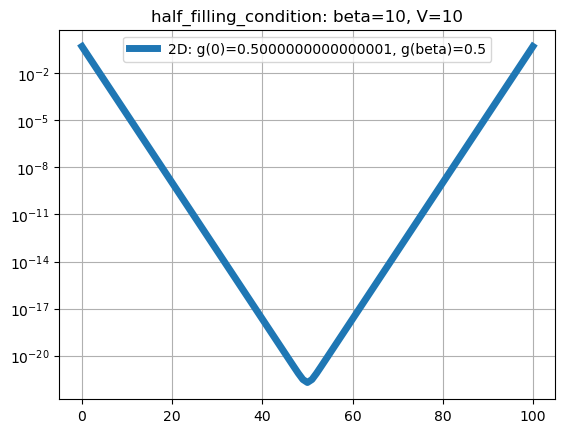

In [25]:
# ED solver
beta = 10
V = 10
ed = 0
# 2D
dim = 2
k = 0
U = np.ones((dim,dim)) +k* np.eye(dim)
tauhyaku = np.linspace(0,beta, 101)
GF_ = GreenFunc(beta, U_matrix=U, bath_num=1, eps_k=[ed], V_k=[V])
g_ed = -1 * GF_.greenarray(tauhyaku)
plt.plot(g_ed, label=f"2D: g(0)={g_ed[0]}, g(beta)={g_ed[-1]}", lw=5)
# # 3D
# dim = 3
# k = 1
# U = np.ones((dim,dim)) +k* np.eye(dim)
# GF_ = GreenFunc(beta, U_matrix=U, bath_num=1, eps_k=[ed], V_k=[V])
# g_ed = -1 * GF_.greenarray(tauhyaku)
# plt.plot(g_ed, label=f"3D: g(0)={g_ed[0]}, g(beta)={g_ed[-1]}", lw=4)
# # 4D
# dim = 4
# k = 2
# U = np.ones((dim,dim)) +k* np.eye(dim)
# GF_ = GreenFunc(beta, U_matrix=U, bath_num=1, eps_k=[ed], V_k=[V])
# g_ed = -1 * GF_.greenarray(tauhyaku)
# plt.plot(g_ed, label=f"4D: g(0)={g_ed[0]}, g(beta)={g_ed[-1]}", lw=3)
# # 5D
# dim = 5
# k = 3
# U = np.ones((dim,dim)) +k* np.eye(dim)
# GF_ = GreenFunc(beta, U_matrix=U, bath_num=1, eps_k=[ed], V_k=[V])
# g_ed = -1 * GF_.greenarray(tauhyaku)
# plt.plot(g_ed, label=f"5D: g(0)={g_ed[0]}, g(beta)={g_ed[-1]}", lw=2)
plt.grid()
plt.yscale("log")
plt.legend()
plt.title(f"half_filling_condition: beta={beta}, V={V}")

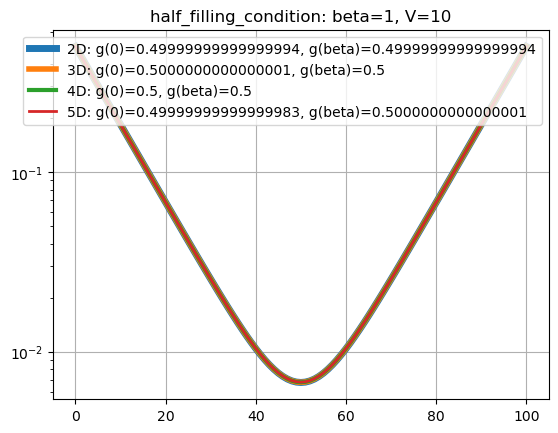

このように5つのフレーバーまでhalfフィリング条件をsolverが満たすことを確認できる。

## 検証2 flavor ct qmcの実行

2サイト模型の厳密解をもとに一般の場合のSU(N) solverの結果を求める。

In [26]:
beta = 1
tauhyaku = np.linspace(0,beta, 101)
tausen = np.linspace(0,beta, 1001)
tauman = np.linspace(0,beta,10001)
V = 10
ed = 2
U_matrix = np.array([
    [1,1,11],
    [1,1,-10],
    [11,-10,1],
])
# U_matrix = np.array([
#     [0,1],
#     [1,0]
# ])
flavor = U_matrix.shape[0]
# U=0の場合のgreen funcとhybridizaiton funcを求める。
hyb_list = []
g0_list = []
for i in range(flavor):
    gf_hyb = GfImFreq(beta=beta, indices=["gf_hyb"])
    gf_hyb << V**2 * inverse(iOmega_n - (ed))
    gf_g0 = GfImFreq(beta=beta, indices=["gf_g0"])
    gf_g0 << inverse(iOmega_n +U_matrix[i][i] - gf_hyb)
    gf_hyb_tau = GfImTime(beta=beta, indices=["gf_hyb_tau"])
    gf_hyb_tau << Fourier(gf_hyb)
    np_hyb_tau = gf_hyb_tau.data.flatten()
    np_hyb_tau = np.append(np_hyb_tau[::10], np_hyb_tau[-1])
    hyb_list.append(-np.flip(np_hyb_tau.real)) # triqsは正の範囲の混成関数をスタートにとるが、flavor ct qmcは負の範囲を入力とる。
    g0_list.append(gf_g0)
hyb = np.column_stack(hyb_list)
hyb.shape

(1001, 3)

/home/fujii/.conda/envs/triqs/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


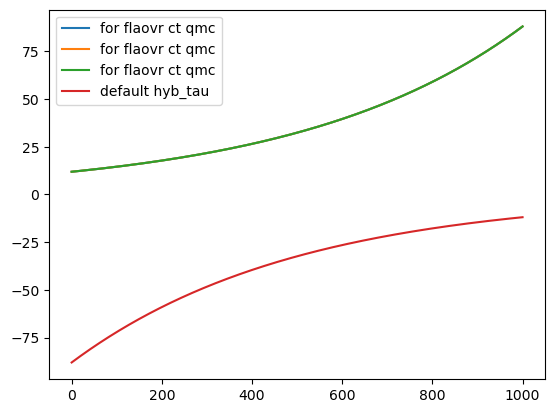

In [27]:
plt.plot(hyb, label="for flaovr ct qmc")
plt.plot(np_hyb_tau, label="default hyb_tau")
plt.legend()

In [28]:
GF_ = GreenFunc(beta, U_matrix=U_matrix, bath_num=1, eps_k=[ed], V_k=[V])
g_ed = -1 * GF_.greenarray(tausen)

In [29]:
with open("./triqs_ct_hyb/input.pickle", "wb") as f:
    pickle.dump({
        "U_matrix": U_matrix,
        "beta": beta,
        "g0_list": g0_list
    },f)

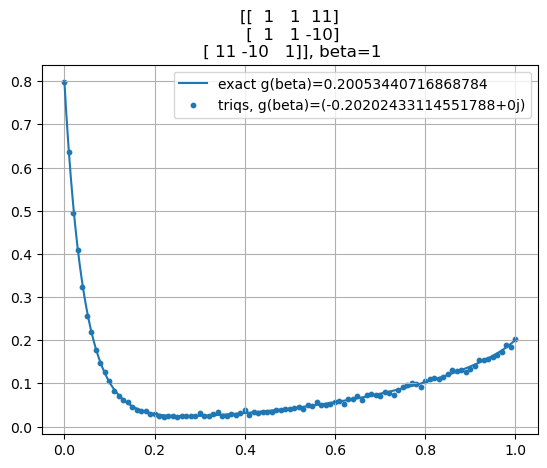

In [30]:
with open("./triqs_ct_hyb/r.pickle", "rb") as f:
    tr = pickle.load(f)
g_triqs = tr["G_tau"]
plt.plot(tausen, g_ed,label=f"exact g(beta)={g_ed[-1]}")
plt.scatter(tauman[::100],-g_triqs[::100], s=10, label=f"triqs, g(beta)={g_triqs[-1]}")
# plt.yscale("log")
plt.grid()
plt.title(f"{U_matrix}, beta={beta}")
plt.legend()

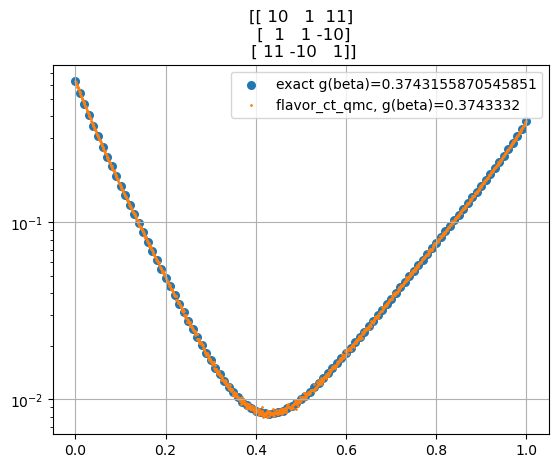
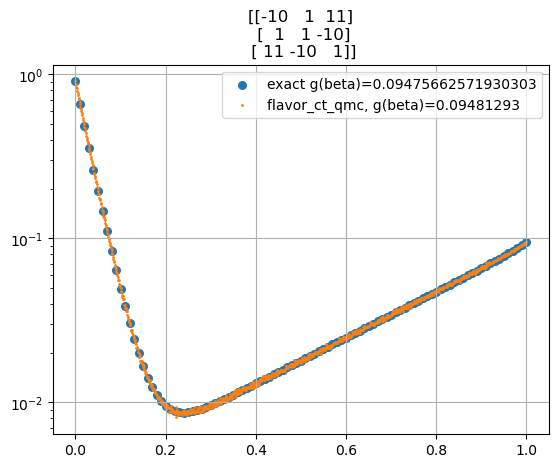
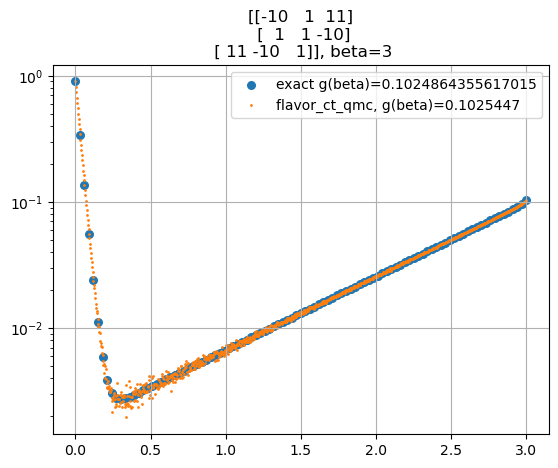
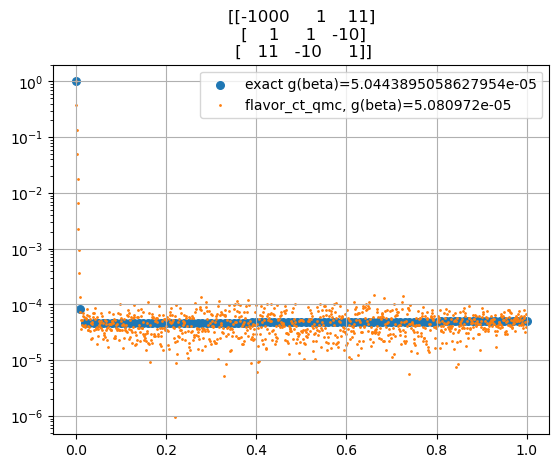
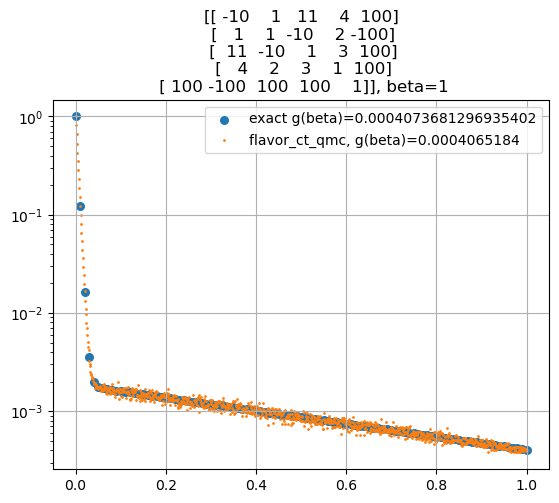
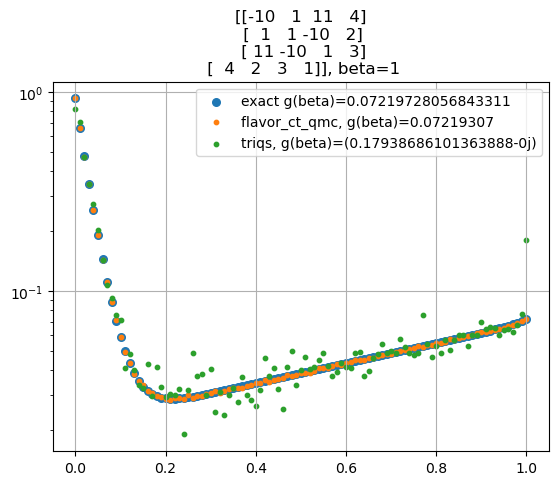
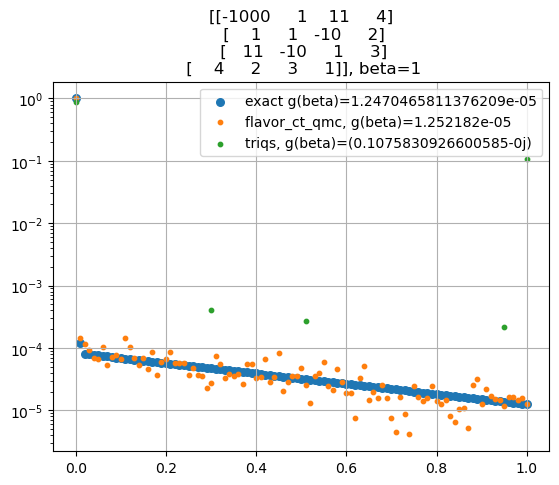

このようにいろいろなU行列を入力しても解析解とflavor ct qmcの導く答えが一致していることが確認できる。
triqsでも実装し、並列数も考慮し、同じ繰り返し回数(10^6)だけ実行した結果。少ない繰り返し回数ではtriqsは収束が悪いことが分かる。